##### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### __This script uses pair of png satellite images (pre- and post-disaster) and corresponding json files with labels pre-disaster (building polygons) and post-disaster (damage level) 
#### to create 4 tensors:__ 

##### 1. pre-image tensor (height,width,3)
##### 2. segmentation mask tensor (height,width,1)
##### 3. post-image tensor (height,width,3)
##### 4. classification mask tensor (height,width,1)

#### 1 and 2 are saved in file --> tensors_pre_[database].npz (useful for segmentation)
#### 3 and 4 are saved in file --> tensors_post_[database].npz (useful for classification)

##### , with [database] the name of the database being used (see variable "database_dir" at the end of this file)

#### __Labels for damage classification (used to create tensor n°4)__
##### Class 0 - no building or un-classified building
##### Class 1 - no-damage
##### Class 2 - minor damage
##### Class 3 - major damage
##### Class 4 - destroyed

#### 1. import the necessary libraries

In [1]:
#import json
#import cv2 
from os import path, walk, makedirs
from sys import exit, stderr

from cv2 import fillPoly, imwrite
import numpy as np
from shapely import wkt
from shapely.geometry import mapping, Polygon
from skimage.io import imread
from tqdm.auto import tqdm
#getattr(tqdm, '_instances', {}).clear() 
#import imantics 
import numpy as np
import tensorflow as tf

# This removes the massive amount of scikit warnings of "low contrast images"
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CHECKING THE CONTENT OF THE NPZ FILES (A LARGE FILE COULD MAKE VSCODE TO CRASH)


In [2]:
# function to plot images and masks
# argument is a list of masks 
import matplotlib.pyplot as plt

def display(display_list):
    plt.figure(figsize=(15, 15))

    
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    # Create the folder if it doesn't exist
    plt.show()

In [3]:
def convert_mask_to_3_channels(mask_1_channel):
    """convert 1 channel mask (numpy array) in 3 channel mask, preserving labels 
    defined in "category_colors" dictionary
    
    Args:
        mask (~numpy.ndarray): A mask array with 1 dimension.
        
    Returns:
        mask (~numpy.ndarray) with 3 channels.
    """
    # Assuming mask_1_channels has shape (height, width, 1)
    height, width = mask_1_channel.shape

    # Create an empty array with shape (height, width, 1) for the single-channel mask
    deep_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Define the colors representing each category (RGB values)
    category_colors = {
        0:(0, 0, 0),        # Class 0 - Black (no building) or un-classified
        1:(255, 255, 255),  # Class 1 - White (no-damage)
        2:(255,255,0),     # Class 2 - Yellow (minor damage)
        3:(255,165,0),     # Class 3 - Orange (major damage)
        4:(255, 0, 0),     # Class 4 - Red (destroyed)
    }
    # Loop through each pixel and assign the corresponding category to the single-channel mask
    for y in range(height):
        for x in range(width):
            pixel_color = mask_1_channel[y, x]
            category = category_colors.get(pixel_color, (-1,-1,-1))  # -1 for unknown category
            deep_mask[y, x] = category

    return deep_mask

## loading tensors pre and post disaster

In [4]:
#to recover tensors:

# LOADING TENSORS
#to recover images and mask arrays:
loaded_arrays_pre = np.load('/Volumes/Elements/data_buidings_challenge/tensors_pre_xBD_last_subset.npz')
images_pre = loaded_arrays_pre['images']
masks_pre = loaded_arrays_pre['masks']
id_pre = loaded_arrays_pre['id']

dis_name = loaded_arrays_pre['disaster_name']
dis_type = loaded_arrays_pre['disaster_type']

In [6]:
dis_name

array(['hurricane-harvey', 'hurricane-harvey', 'hurricane-harvey', ...,
       'socal-fire', 'socal-fire', 'socal-fire'], dtype='<U19')

In [5]:
#to recover tensors:

# LOADING TENSORS
#to recover images and mask arrays:
# loaded_arrays_post = np.load('/Volumes/Elements/data_buidings_challenge/tensors_post_xBD_last_subset.npz')
# images_post = loaded_arrays_post['images']
# masks_post = loaded_arrays_post['masks']
# id_post = loaded_arrays_post['id']


## Plotting

In [6]:
# range for the number of pair of images
im1 = 0
im2 = images_pre.shape[0]
print("range = ({},{})".format(im1,im2-1))

range = (0,1352)


In [6]:
from sklearn.model_selection import train_test_split
id_train, id_val= train_test_split(id_pre, test_size=0.2, 
                                                      random_state=0
                                                     )

In [13]:
len(id_val)

271

In [35]:
#n_image=list(id_post).index("socal-fire_00001292_post_disaster")

In [7]:
# chose the number of image to inspect
#n_image=453 --> For xBD_last_subset. It has all the colors
n_image=1

### PRE DISASTER

In [8]:
# PRE DISASTER
# checking size
print(images_pre.shape)
print(masks_pre.shape)
print(id_pre.shape)
print(dis_name.shape)
print(dis_type.shape)


print("ID: ",id_pre[n_image])
print("name: ",dis_name[n_image])
print("type: ",dis_type[n_image])

# to see the pixel values of only mask number 5
#print(images_pre[5, :, :, 1].shape)
#see the values that fill the mask number 5 
#print(np.unique(masks_pre[0, :, :, 0])) # [0 1 4] --> only buildings with damage levels 1 and 4 in this

(1353, 1024, 1024, 3)
(1353, 1024, 1024, 1)
(1353,)
(1353,)
(1353,)
ID:  hurricane-harvey_00000513_pre_disaster
name:  hurricane-harvey
type:  flooding


midwest-flooding_00000317_pre_disaster


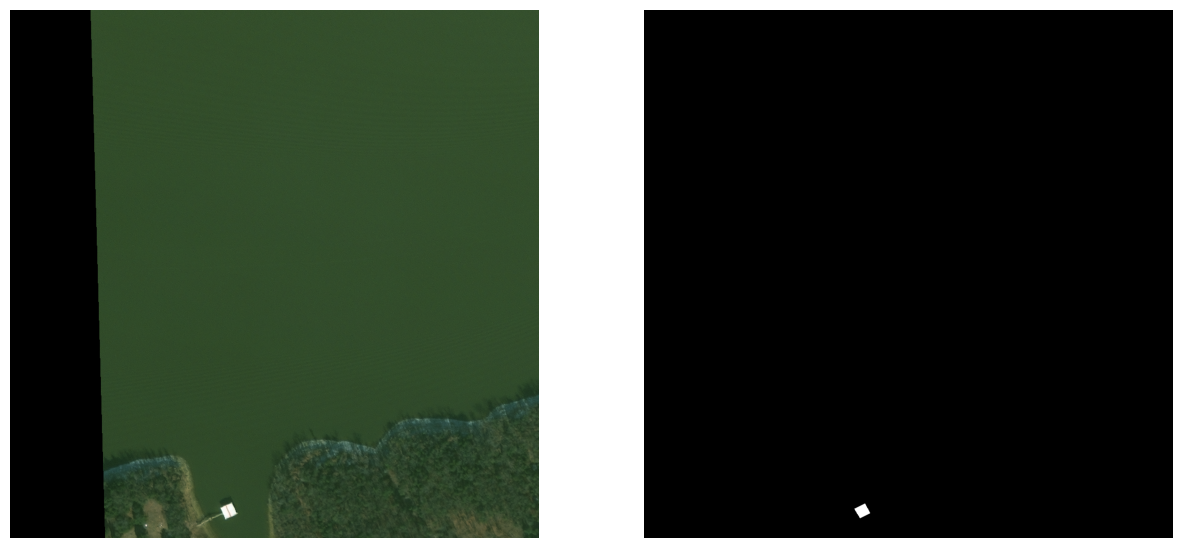

hurricane-florence_00000120_pre_disaster


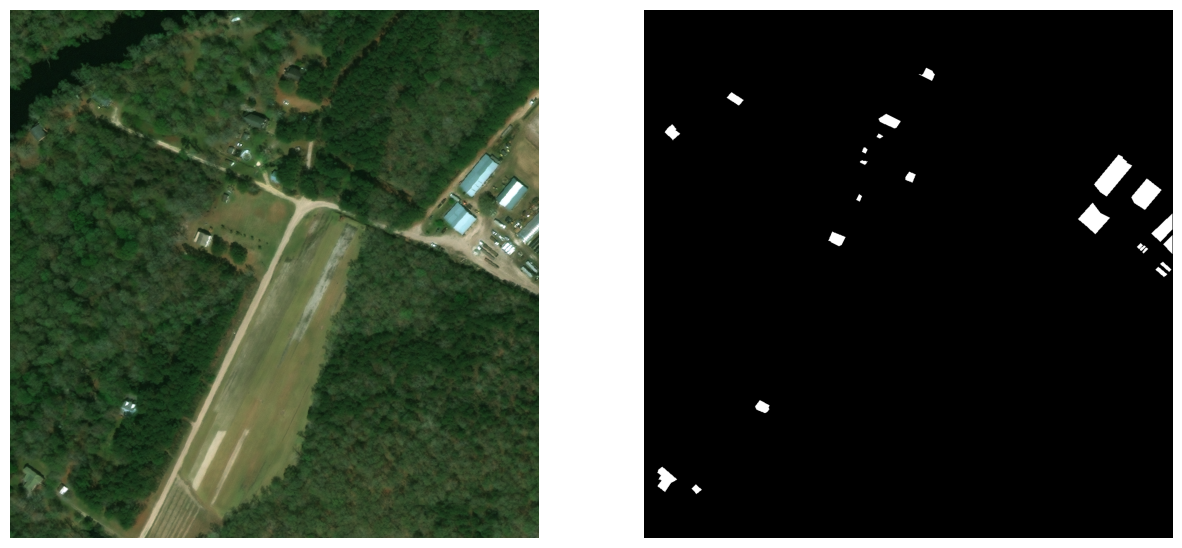

socal-fire_00001292_pre_disaster


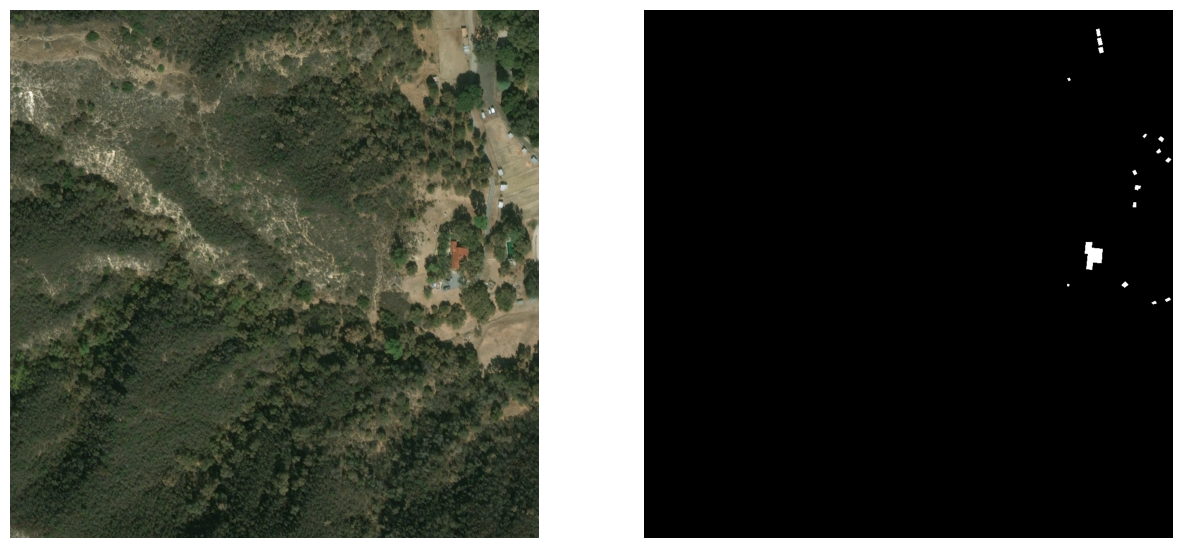

hurricane-harvey_00000293_pre_disaster


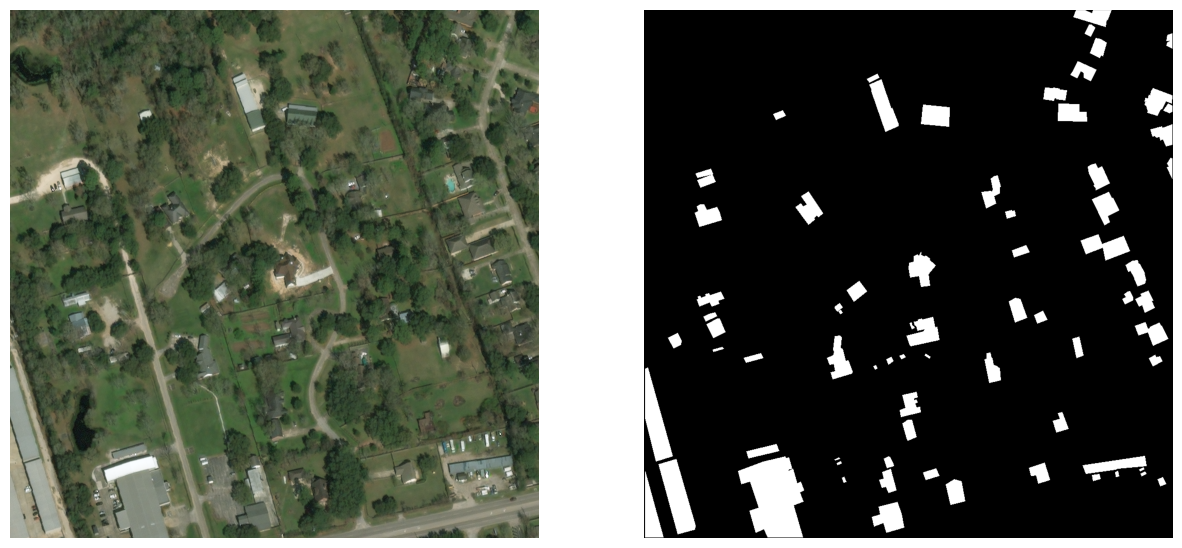

hurricane-florence_00000514_pre_disaster


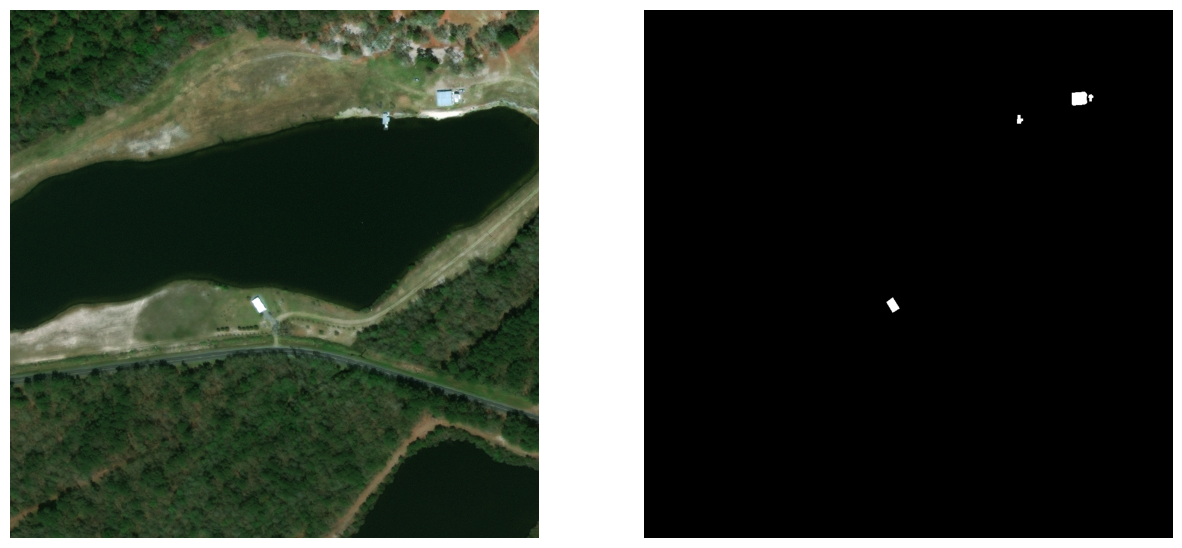

hurricane-florence_00000148_pre_disaster


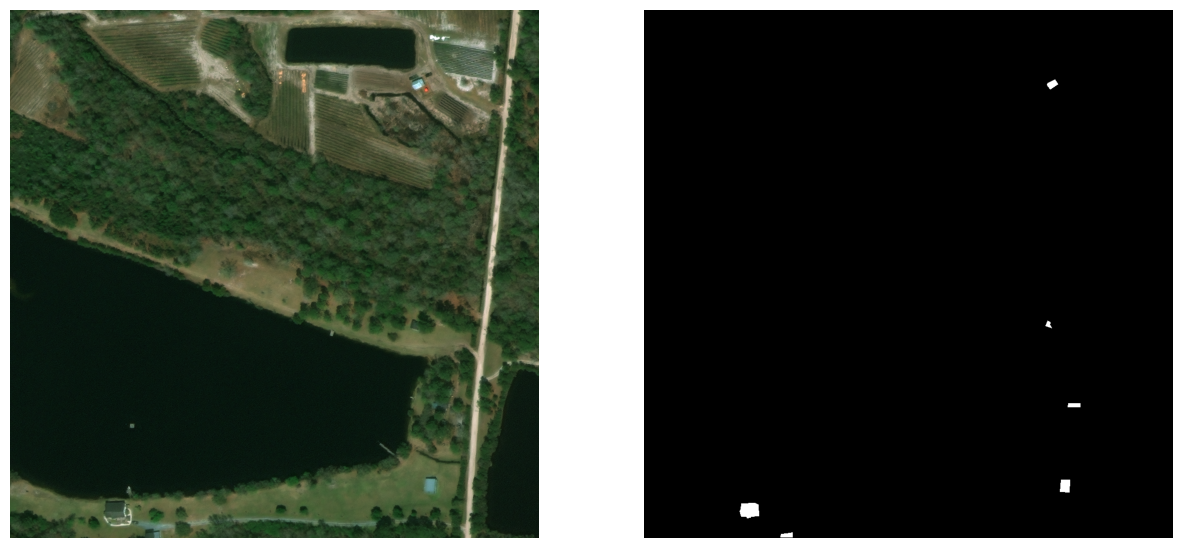

santa-rosa-wildfire_00000070_pre_disaster


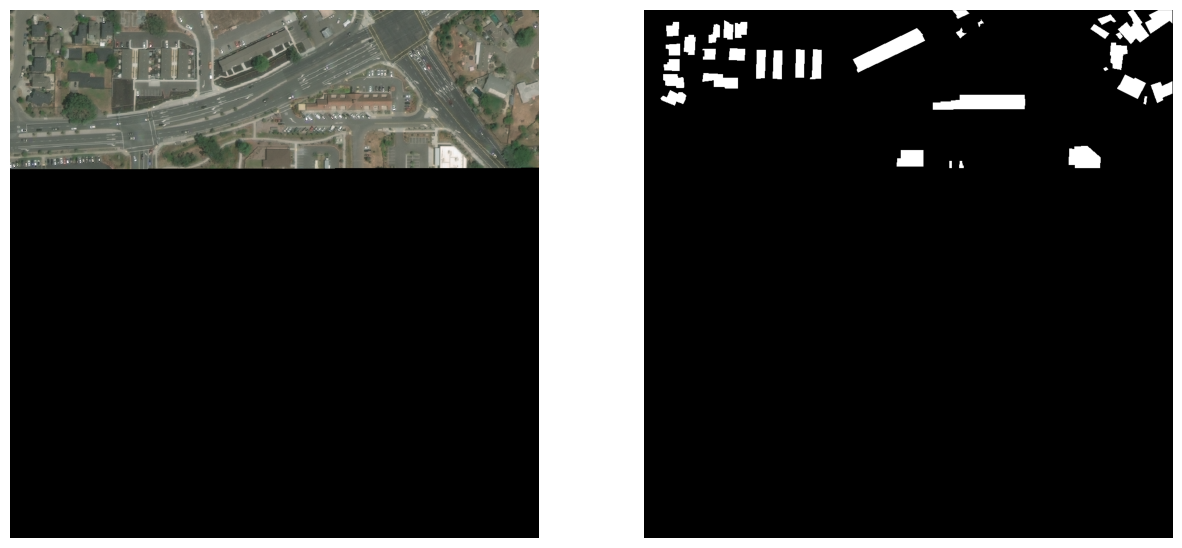

socal-fire_00001127_pre_disaster


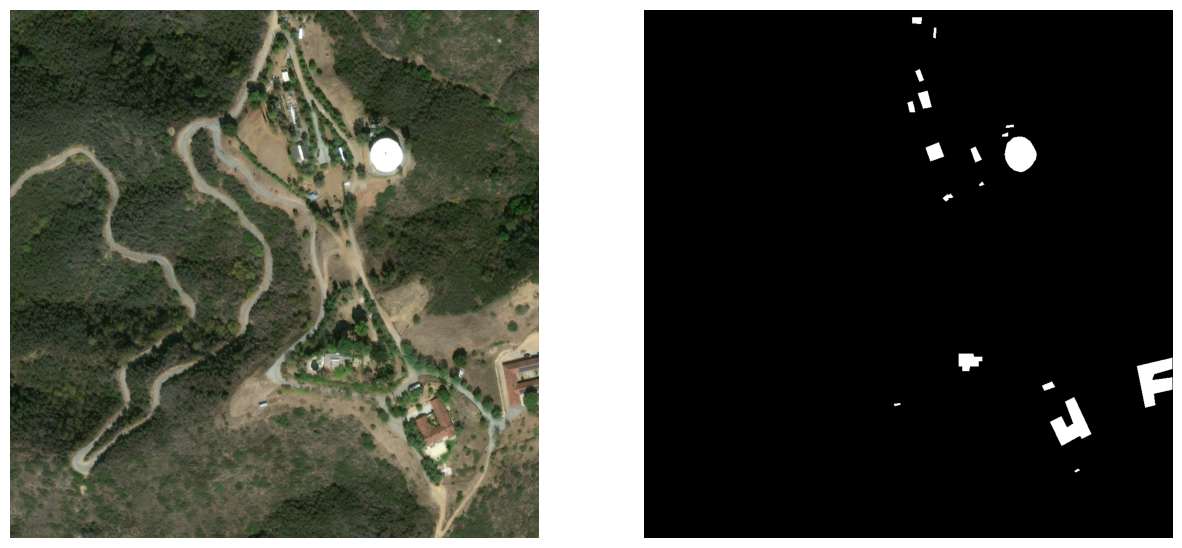

hurricane-harvey_00000244_pre_disaster


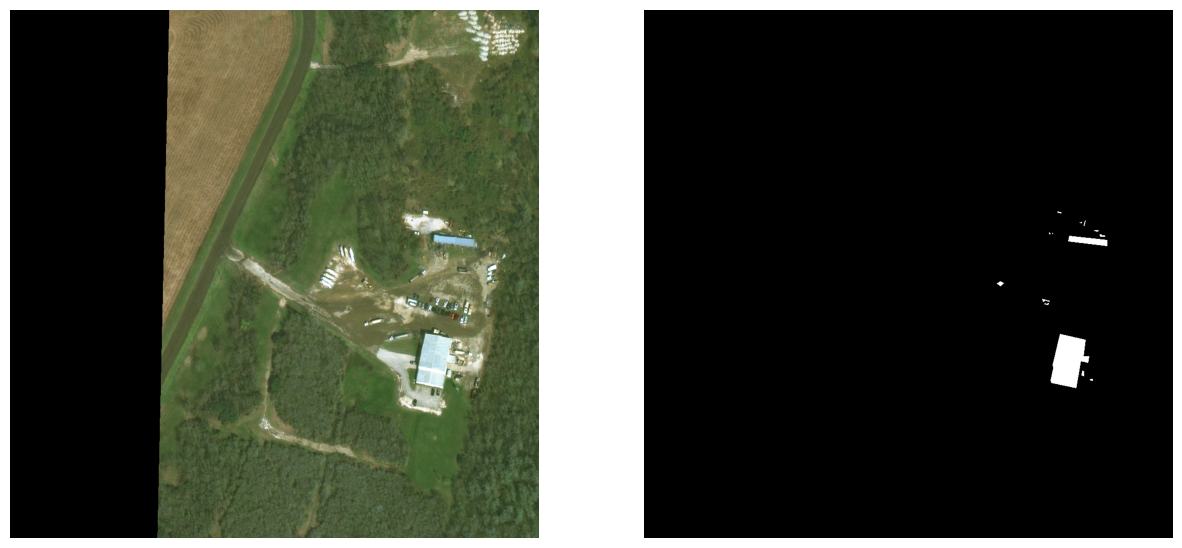

hurricane-matthew_00000328_pre_disaster


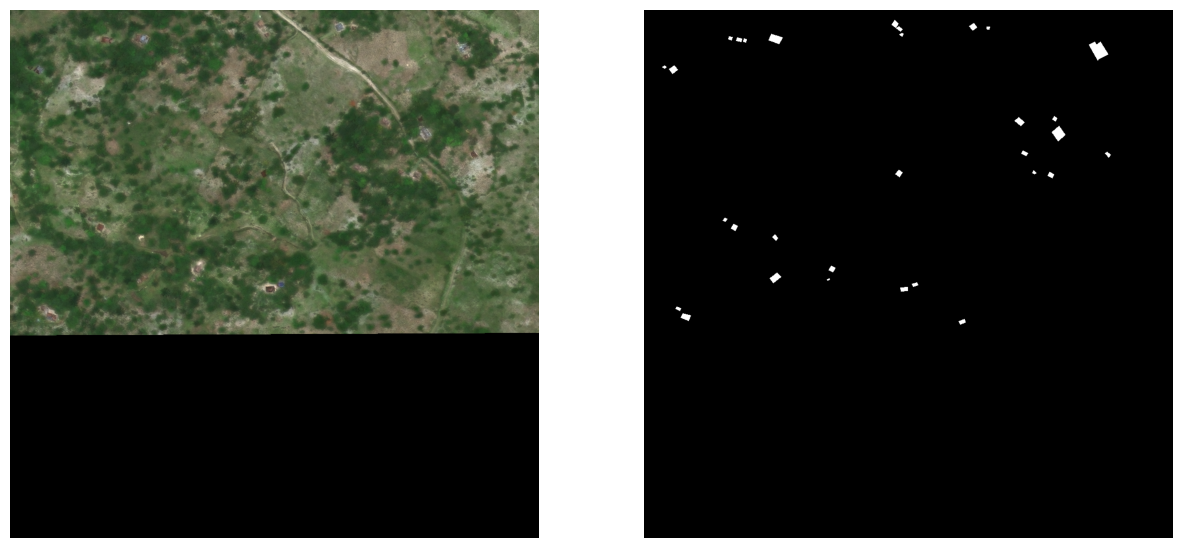

hurricane-florence_00000477_pre_disaster


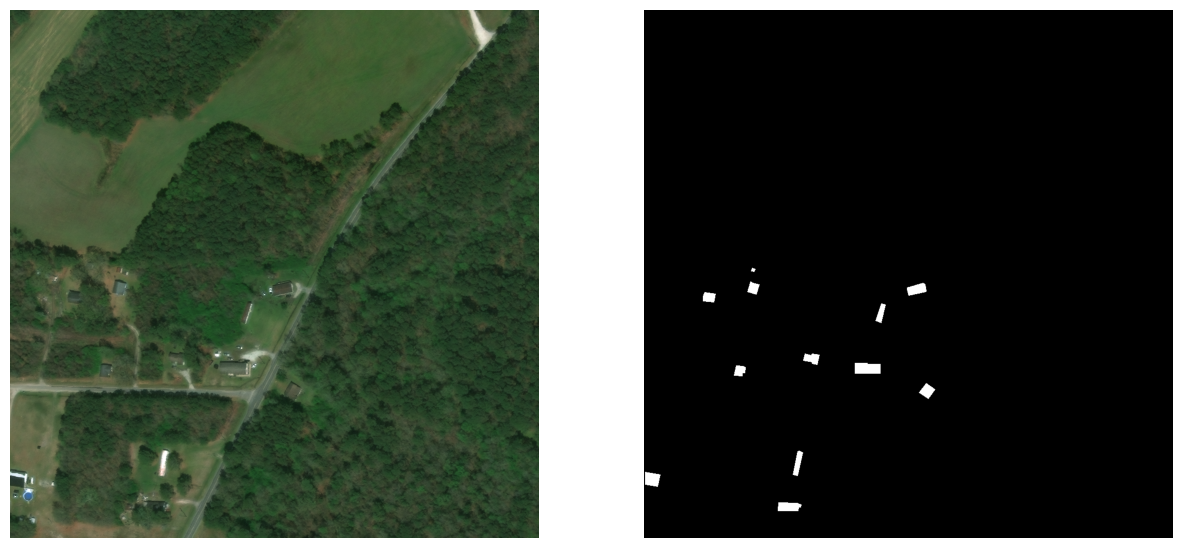

hurricane-matthew_00000002_pre_disaster


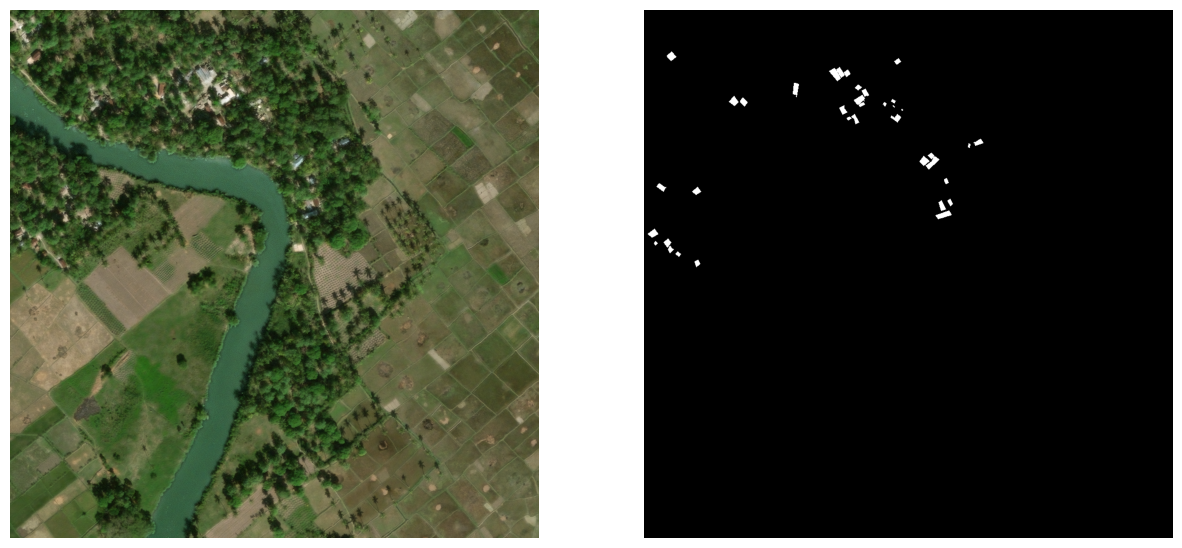

socal-fire_00000716_pre_disaster


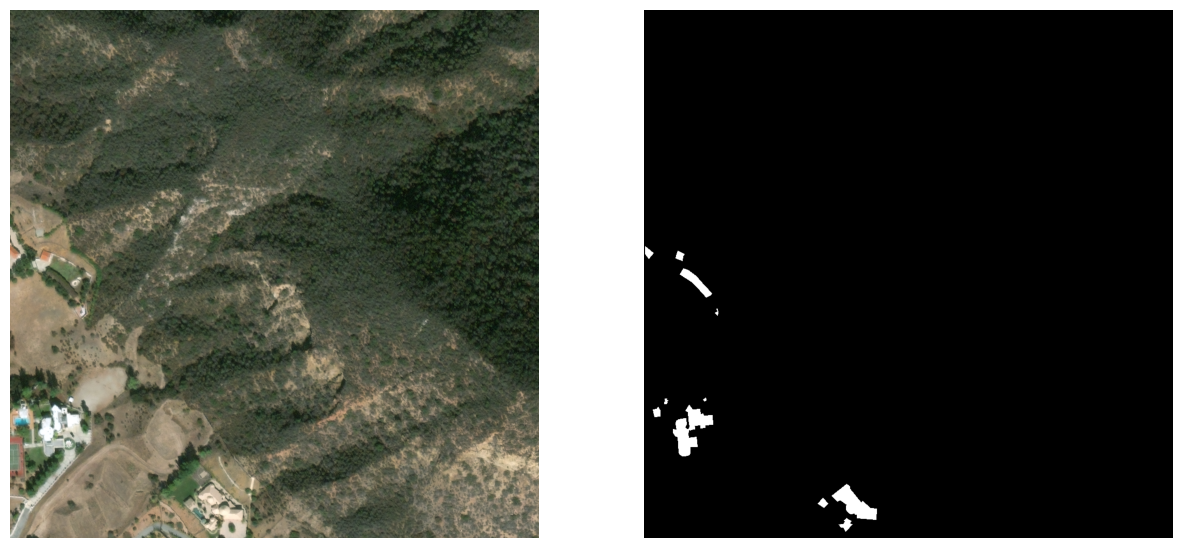

KeyboardInterrupt: 

In [14]:
# this is a cell that visualize the validation data from pre or post (change pre or post accordingly)
#n_image=list(id_pre).index(id_val[0:10])
for id in id_val:
    n = list(id_pre).index(id)

    imagepre = images_pre[n, :, :, :]
    maskpre = masks_pre[n, :, :, 0]
    #maskpre_deep = tf.expand_dims(maskpre, -1)
    #print(type(maskpre))
    maskpre_deep = convert_mask_to_3_channels(maskpre)
    print(id)
    display([imagepre,maskpre_deep]) 

<class 'numpy.ndarray'>
(1024, 1024, 3)


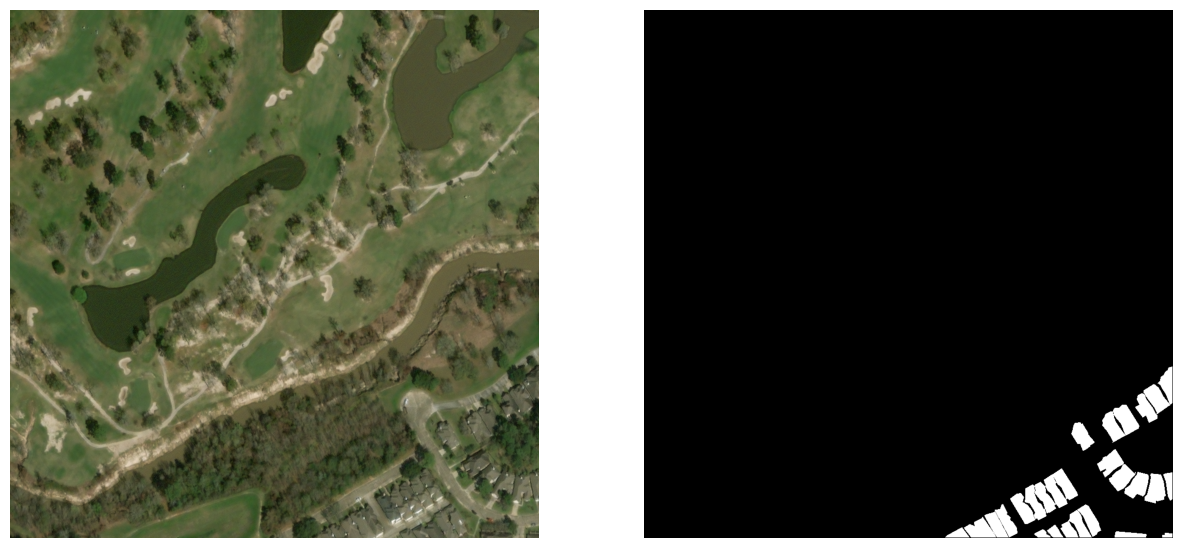

In [9]:
# plot pre

imagepre = images_pre[n_image, :, :, :]
maskpre = masks_pre[n_image, :, :, 0]
#maskpre_deep = tf.expand_dims(maskpre, -1)
print(type(maskpre))
maskpre_deep = convert_mask_to_3_channels(maskpre)
print(maskpre_deep.shape)
display([imagepre,maskpre_deep])    

### POST DISASTER

In [36]:
# PRE DISASTER
# checking size
#print(images_post.shape)
#print(masks_post.shape)
#print(id_post.shape)

print("ID: ",id_post[n_image])
# to see the pixel values of only mask number 5
#print(images_pre[5, :, :, 1].shape)
#see the values that fill the mask number 5 
#print(np.unique(masks_pre[0, :, :, 0])) # [0 1 4] --> only buildings with damage levels 1 and 4 in this

ID:  socal-fire_00001292_post_disaster


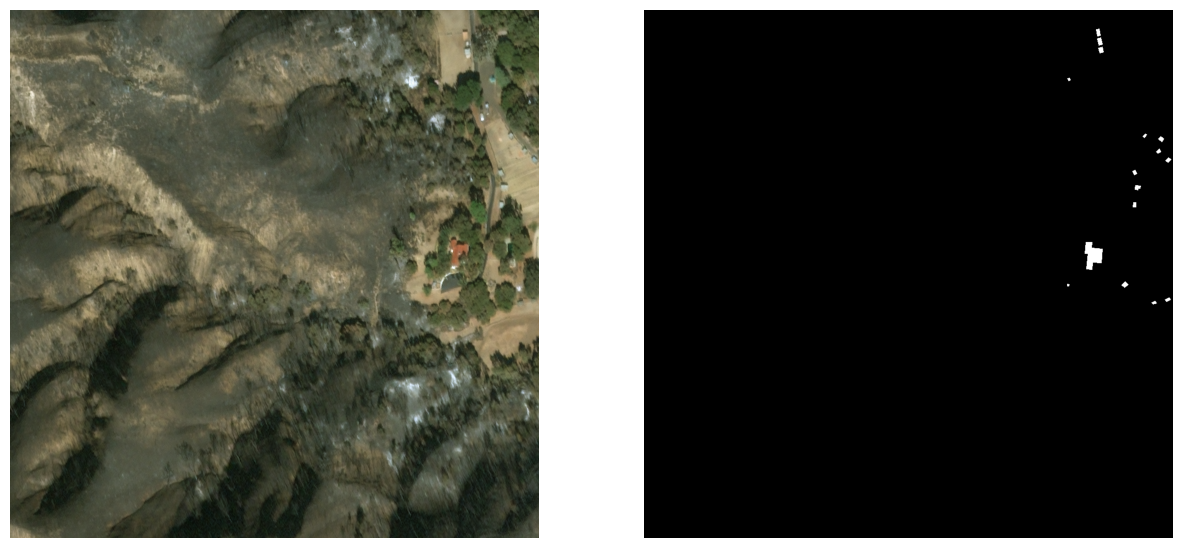

In [38]:
# plot post
imagepost = images_post[n_image, :, :, :]
maskpost = masks_post[n_image, :, :, 0]
#maskpost_deep = tf.expand_dims(maskpost, -1)
maskpost_deep = convert_mask_to_3_channels(maskpost)
display([imagepost,maskpost_deep])    

In [10]:
# type of disasters
print(np.unique(dis_type))

['earthquake' 'fire' 'flooding' 'tsunami' 'volcano' 'wind']


In [11]:
# name of different disasters
print(np.unique(dis_name))

['guatemala-volcano' 'hurricane-florence' 'hurricane-harvey'
 'hurricane-matthew' 'hurricane-michael' 'mexico-earthquake'
 'midwest-flooding' 'palu-tsunami' 'santa-rosa-wildfire' 'socal-fire']


In [12]:
# Create a dictionary to count occurrences of each unique disaster_type
disaster_type_counts = {}
for disaster_type in dis_type:
    if disaster_type in disaster_type_counts:
        disaster_type_counts[disaster_type] += 1
    else:
        disaster_type_counts[disaster_type] = 1
disaster_type_counts        

{'flooding': 500,
 'fire': 353,
 'wind': 345,
 'tsunami': 68,
 'earthquake': 75,
 'volcano': 12}

In [13]:
import random

def get_subset_with_homogeneous_distribution(data_loaded, desired_num_samples_per_category):
    # Load the data from tensor.npz
    data = data_loaded

    # Extract the disaster_type array
    disaster_type_all = data['disaster_type']

    # Create a dictionary to group indices by disaster_type
    indices_by_disaster_type = {}
    for i, disaster_type in enumerate(disaster_type_all):
        if disaster_type in indices_by_disaster_type:
            indices_by_disaster_type[disaster_type].append(i)
        else:
            indices_by_disaster_type[disaster_type] = [i]

    # Initialize variables to keep track of selected samples
    selected_indices = []

    # Iterate through each disaster_type and randomly select samples
    for disaster_type, indices in indices_by_disaster_type.items():
        num_samples_to_select = min(desired_num_samples_per_category, len(indices))
        selected_samples = random.sample(indices, num_samples_to_select)
        selected_indices.extend(selected_samples)

    # Shuffle the selected indices to mix up the disaster types
    random.shuffle(selected_indices)

    # Use the selected indices to extract the subset of images, masks, and other relevant data
    images_subset = data['images'][selected_indices]
    masks_subset = data['masks'][selected_indices]
    id_subset = data['id'][selected_indices]
    disaster_name_subset = data['disaster_name'][selected_indices]
    disaster_type_subset = data['disaster_type'][selected_indices]

    return images_subset, masks_subset, id_subset, disaster_name_subset, disaster_type_subset

In [14]:
desired_num_samples = 5
# pre
images_subset_pre, masks_subset_pre, id_subset_pre, disaster_name_subset, disaster_type_subset = get_subset_with_homogeneous_distribution(loaded_arrays_pre, desired_num_samples)
# post
#images_subset_post, masks_subset_post, id_subset_post, disaster_name_subset, disaster_type_subset = get_subset_with_homogeneous_distribution(loaded_arrays_post, desired_num_samples)

database_pre="tensors_pre_xBD_mini"
#database_post="tensors_post_xBD_last_subset"

np.savez('tensors_pre_subset_'+database_pre+'.npz', images=images_subset_pre, masks=masks_subset_pre, id=id_subset_pre, disaster_name=disaster_name_subset, disaster_type=disaster_name_subset)
#np.savez('tensors_post_subset_'+database_post+'.npz', images=images_subset_post, masks=masks_subset_post, id=id_subset_post, disaster_name=disaster_name_subset, disaster_type=disaster_name_subset)



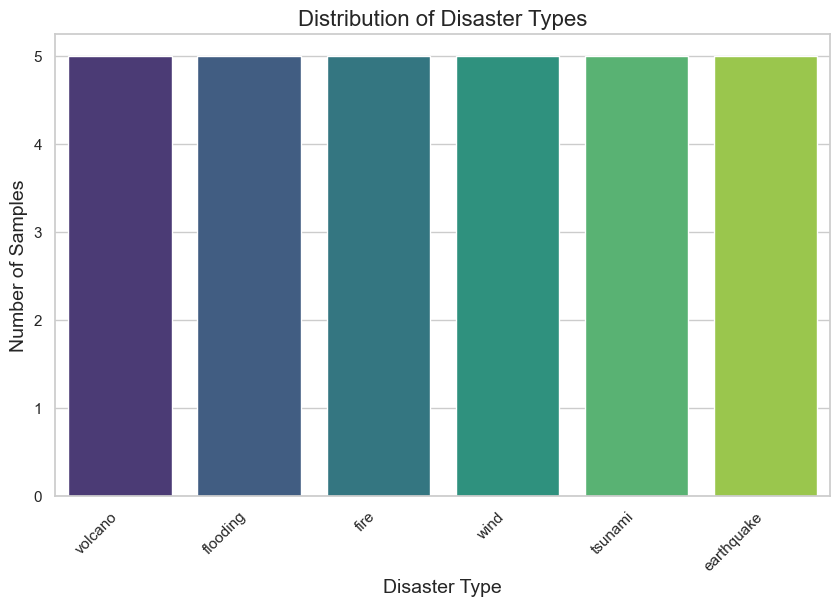

In [15]:
#!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming "disaster_type_subset" is a numpy array or list containing the disaster types
# Make sure you have Seaborn and Matplotlib installed

# Create a countplot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=disaster_type_subset, palette="viridis")

# Customize the plot
plt.xlabel("Disaster Type", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Distribution of Disaster Types", fontsize=16)
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()
